<a href="https://colab.research.google.com/github/shuyu-wu/bitcoin-prediction/blob/master/bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load libraries

In [0]:
import pandas as pd
# from langdetect import detect, DetectorFactory
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,RNN,GRU
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle
from keras.models import load_model
import re
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import itertools
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import statsmodels.api as sm
from itertools import product
from fbprophet import Prophet



# PART 1

## Load real time dataset

In [0]:
tweets_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tweets_v1.csv')

In [0]:
tweets_df.text.isnull().sum()

718

In [0]:
tweets_df.text.dropna(inplace=True)

## Filter English tweets

In [0]:
def filter_english (x):
    try:
        if detect(x) == 'en':
            return x
        else:
            return 0
    except: return 0

In [0]:
tw = tweets_df.copy()
tw['text'] = tw.text.apply(filter_english)

In [0]:
tw.shape

(1851563, 10)

In [0]:
tw.tail()

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text,html
1851558,hanamoto7839,与沢翼ファンクラブ,1085491142202781696,2019-01-16 10:57:10,/hanamoto7839/status/1085491142202781696,2,0,0,0,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1851559,skskwwwww,S(つд⊂)さく,1085491133143179265,2019-01-16 10:57:08,/skskwwwww/status/1085491133143179265,1,0,0,0,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1851560,BTC_shoshinsha,ツーカー,1085491126495137792,2019-01-16 10:57:06,/BTC_shoshinsha/status/1085491126495137792,2,1,0,0,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1851561,HRleaderRich,Rich Brown,1085491114906398720,2019-01-16 10:57:03,/HRleaderRich/status/1085491114906398720,0,0,0,"""Bitcoin - A method of secure transactions bas...","<p class=""TweetTextSize js-tweet-text tweet-te..."
1851562,BotDjulian,Djulian [Bot],1085491108665163777,2019-01-16 10:57:02,/BotDjulian/status/1085491108665163777,3,0,4,MARKET BRAZIL CC SHOP [http://54ce5x7l4m3t2spm...,"<p class=""TweetTextSize js-tweet-text tweet-te..."


In [0]:
tw.to_csv('/content/drive/My Drive/Colab Notebooks/preprocessed.csv')


In [0]:
prepr_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/preprocessed.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,4,5,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
prepr_df = prepr_df.loc[prepr_df['text']!='0']

In [0]:
prepr_df.head()

,Unnamed: 0,timestamp,clean_tweets
0,0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...
1,1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...
2,2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...
3,3,2016-06-25 23:59:15,What are the merits and risks of investing in ...
4,4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...


In [0]:
prepr_df.to_csv('/content/drive/My Drive/Colab Notebooks/prepr.csv')

In [0]:
prepr_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/prepr.csv')

In [0]:
prepr_df=prepr_df[['timestamp','text']]

In [0]:
prepr_df.head()

,Unnamed: 0,timestamp,clean_tweets
0,0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...
1,1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...
2,2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...
3,3,2016-06-25 23:59:15,What are the merits and risks of investing in ...
4,4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...


## Preprocess the data

### Loading train labeled dataset

In [0]:
labeled_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bitcointweets.csv',header=None)

In [0]:
labeled_df.head()

,0,1,2,3,4,5,6,7
0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,16522,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral']
1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,1295,0,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral']
2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,6090,0,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,2626,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,184,0,[],"<a href=""http://twitter.com/download/android"" ...",['positive']


In [0]:
labeled_df = labeled_df[[0,1,7]]
labeled_df.columns = ['date','tweets','sentiment']

['positive']    45.099196
['neutral']     43.136908
['negative']    11.763896
Name: sentiment, dtype: float64

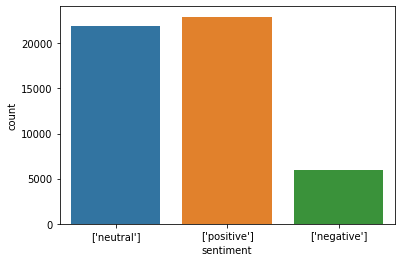

In [0]:
sns.countplot(labeled_df['sentiment'])
labeled_df['sentiment'].value_counts(normalize=True) * 100

In [0]:
labeled_df['date'] = pd.to_datetime(labeled_df['date'])

In [0]:
def clean_text(s):
    s = re.sub(r'http\S+', '', str(s))
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', str(s))
    s = re.sub(r'@\S+', '', str(s))
    s = re.sub('&amp', ' ', str(s))
    return s

In [0]:
labeled_df['clean_tweets'] = labeled_df['tweets'].apply(clean_text)

In [0]:
labeled_df.drop(['tweets'],axis=1, inplace=True)

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

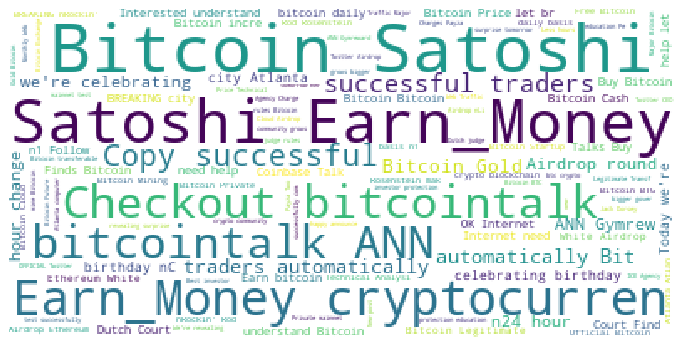

In [0]:
text = labeled_df["clean_tweets"].to_string()
wordcloud = WordCloud(relative_scaling=0.5 , background_color='white',stopwords=set(stopwords.words('english'))).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Train Test Split

In [0]:
X = labeled_df["clean_tweets"]
y = pd.get_dummies(labeled_df["sentiment"].values)
y.head()

,['negative'],['neutral'],['positive']
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [0]:
y = np.array(y)
num_classes = labeled_df["sentiment"].nunique()

In [0]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)


In [0]:
X_train

28589    #cryptkeeper How much money can bitcoin miners...
15363    You love your laptop, but its WiFi network ada...
10609     : #Bitcoin #Satoshi #Earn_Money #cryptocurren...
29157     : Here reporting from Blockchain  ; Bitcoin C...
9683      : #Bitcoin #cryptocurrency  #Airdrop\nNew Air...
                               ...                        
11284    TRON (TRX) Airdrop Free 352 USD\n#airdrop #bou...
44732     : We have been attending a lot of conferences...
38158    Shocking, Secret Facts Part IIII  $btcusd #bit...
860                                2) whispered.\n#bitcoin
15795     : Official Bitcoin Cloud #Airdrop 1\n\n\n\nLi...
Name: clean_tweets, Length: 40687, dtype: object

In [0]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

### Tokenize the words

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

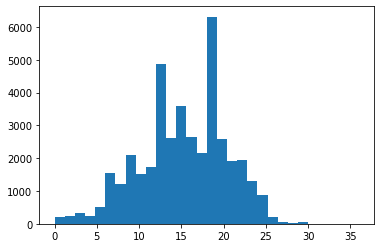

In [0]:
totalNumWords = [len(one_cleaned_tweet) for one_cleaned_tweet in X_train]
plt.hist(totalNumWords,bins=30)
plt.show()

In [0]:
max_words = max(totalNumWords)
X_train = sequence.pad_sequences(X_train , maxlen = max_words)
X_test = sequence.pad_sequences(X_test , maxlen = max_words)
print(X_train.shape,X_test.shape)

(40687, 36) (10172, 36)


## Construct model

### Baseline model - Random Forest

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.2, random_state=42)


In [0]:
random_forest = RandomForestClassifier(random_state=123)
random_forest.fit(X_train,y_train)
print(random_forest.score(X_train, y_train))
print(random_forest.score(X_val, y_val))

0.9999078312697779
0.8354632587859425


### GRU model

In [0]:
def get_model_gru(max_features , embed_dim):
    np.random.seed(42)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features , embed_dim , input_length=X_train.shape[1]))
    model.add(GRU(100 , dropout=0.2 , recurrent_dropout=0.2))
    model.add(Dense(num_classes , activation='softmax'))
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    print(model.summary())
    return model

In [0]:
max_features = 20000
embed_dim =100
gru_model = get_model_gru(max_features,embed_dim)
model_train(gru_model)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 100)           2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 2,060,603
Trainable params: 2,060,603
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40687 samples, validate on 10172 samples
Epoch 1/3





 - 27s - loss: 0.3181 - acc: 0.8810 - val_loss: 0.1046 - val_acc: 0.9696
Epoch 2/3
 -

### LSTM model

In [0]:
batch_size = 128
epochs = 3

In [0]:
def get_model(max_features , embed_dim):
    np.random.seed(42)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features , embed_dim , input_length=X_train.shape[1]))
    model.add(LSTM(100 , dropout=0.2 , recurrent_dropout=0.2))
    model.add(Dense(num_classes , activation='softmax'))
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    print(model.summary())
    return model

In [0]:
def model_train(model):
    #training the model
    model_history = model.fit(X_train , y_train , validation_data = (X_test , y_test), 
                              epochs = epochs ,batch_size= batch_size,verbose = 2)
    return model_history

In [0]:
max_features = 20000
embed_dim =100
lstm_model = get_model(max_features,embed_dim)
lstm_model_train(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 100)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 2,080,703
Trainable params: 2,080,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 32549 samples, validate on 10172 samples
Epoch 1/3
 - 38s - loss: 0.3843 - acc: 0.8500 - val_loss: 0.1341 - val_acc: 0.9569
Epoch 2/3
 - 36s - loss: 0.0726 - acc: 0.9791 - val_loss: 0.0962 - val_acc: 0.9714
Epoch 3/3
 - 36s - loss: 0.0297 - acc: 0.9918 - val_loss: 0.1080 - val_acc: 0.9729


### Evaluate on test dataset

In [0]:
def model_evaluate(model):
    #predict classes with test set
    y_pred_test = model.predict_classes(X_test , batch_size = batch_size, verbose =0)
    print("Predicted ", y_pred_test)
    print("True " , np.argmax(y_test,axis = 1))
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis = 1),y_pred_test)*100))
    
    #Classification Report
    print("\n")
    print(classification_report(np.argmax(y_test, axis =1),y_pred_test))
    
    #Confusion Matrix
    confmat = confusion_matrix(np.argmax(y_test , axis = 1), y_pred_test)
    fig , ax = plt.subplots(figsize=(4,4))
    ax.matshow(confmat , cmap =plt.cm.Blues , alpha = 0.3)
    
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text( x = j , y = i , s =confmat[i,j] , va = 'center' , ha = 'center')
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

Predicted  [0 0 1 ... 1 0 2]
True  [0 0 1 ... 1 0 2]
Accuracy:	97.6%


              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1164
           1       0.98      0.98      0.98      4345
           2       0.98      0.98      0.98      4663

    accuracy                           0.98     10172
   macro avg       0.97      0.96      0.97     10172
weighted avg       0.98      0.98      0.98     10172



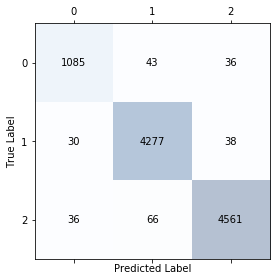

In [0]:
model_evaluate(gru_model)

### Store model

In [0]:
pickle.dump(gru_model, open("/content/drive/My Drive/Colab Notebooks/gru_model_v1.p", "wb"))

## Playground: Pre-trained NLTK model

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
prepr_df

,Unnamed: 0,timestamp,clean_tweets
0,0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...
1,1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...
2,2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...
3,3,2016-06-25 23:59:15,What are the merits and risks of investing in ...
4,4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...
...,...,...,...
3294884,3707951,2019-01-16 10:57:11,What the #Bitcoin #Pizza is worth today! …
3294885,3707952,2019-01-16 10:57:11,Bankrupt Bitcoin Miner Giga Watt Forced to Cea...
3294886,3707953,2019-01-16 10:57:11,#crypto #bitcoin #blockchain …
3294887,3707957,2019-01-16 10:57:03,"""Bitcoin - A method of secure transactions bas..."


In [0]:
sid = SentimentIntensityAnalyzer()
sentiment_score = sid.polarity_scores(labeled_df['clean_tweets'][1])

In [0]:
sentiment_score

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [0]:
%time   #to calulate the time it takes the algorithm to compute a VADER score
i=0 #counter
compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores
while (i<len(labeled_df)):

    k = sid.polarity_scores(labeled_df.iloc[i]['clean_tweets'])
    compval1.append(k['compound'])    
    i = i+1   
#converting sentiment values to numpy for easier usage
compval1 = np.array(compval1)
len(compval1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


50859

In [0]:
labeled_df['VADER_score'] = compval1

In [0]:
labeled_df.head()

,date,sentiment,clean_tweets,VADER_score
0,2018-03-23 00:40:32+00:00,['neutral'],": Paul Krugman, Nobel Luddite. I had to tweak...",-0.6808
1,2018-03-23 00:40:34+00:00,['neutral'],But (dum b a ss) said you know nothing ab...,0.0000
2,2018-03-23 00:40:35+00:00,['positive'],: Another use case for #blockchain and #Tippe...,0.0000
3,2018-03-23 00:40:36+00:00,['positive'],free coins,0.5106
4,2018-03-23 00:40:36+00:00,['positive'],: WE are happy to announce that PayVX Presale...,0.6114


In [0]:
%time
#Assigning score categories and logic
i = 0
predicted_value = [ ] #empty series to hold our predicted values
while(i<len(labeled_df)):
    if ((labeled_df.iloc[i]['VADER_score'] >= 0.2)):
        predicted_value.append('positive')
        i = i+1
    elif ((labeled_df.iloc[i]['VADER_score'] >= -0.5) & (labeled_df.iloc[i]['VADER_score'] < 0.2)):
        predicted_value.append('neutral')
        i = i+1
    else:
        predicted_value.append('negative')
        i = i+1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [0]:
labeled_df['predicted_sentiment'] = predicted_value

In [0]:
labeled_df.tail(50)

,date,sentiment,clean_tweets,VADER_score,predicted_sentiment
50809,2018-03-23 08:54:56+00:00,['positive'],: Great news! Aeron Pilot application now in ...,0.6588,positive
50810,2018-03-23 08:54:58+00:00,['positive'],: Here reporting from Blockchain ; Bitcoin C...,0.8977,positive
50811,2018-03-23 08:55:00+00:00,['neutral'],5 min #RSI Signals:\n\n$BTC - $BRK: 1.02\n$BTC...,0.0000,neutral
50812,2018-03-23 08:55:00+00:00,['positive'],: We are very pleased to announce we are star...,0.9268,positive
50813,2018-03-23 08:55:00+00:00,['positive'],The latest Chatback #Security News! Thanks to...,0.4926,positive
50814,2018-03-23 08:55:00+00:00,['negative'],Bitcoin Will Be World's 'Single Currency' Says...,0.0000,neutral
50815,2018-03-23 08:55:02+00:00,['neutral'],College students are using student loans to in...,0.0000,neutral
50816,2018-03-23 08:55:02+00:00,['positive'],: After a successful launch of our Bounty cam...,0.5859,positive
50817,2018-03-23 08:55:02+00:00,['neutral'],: It's been 72 hours since the official launc...,0.3818,positive
50818,2018-03-23 08:55:03+00:00,['negative'],: Use the code: HF18BDAY30 at purchase to get...,-0.2263,neutral


## Load best performed model

In [0]:
gru_model = pickle.load(open("/content/drive/My Drive/Colab Notebooks/gru_model_v1.p", "rb"))

In [0]:
prepr_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleanprep.csv',header=None)

In [0]:
prepr_df.head()
prepr_df.rename(columns={0:'timestamp',2:'text'},inplace=True)

In [0]:
prepr_df.drop(columns=[1,3,4],inplace=True)

In [0]:
prepr_df.head()

,timestamp,text
0,2018-07-11 19:35:15.363270,"b""Next two weeks prob v boring (climb up to 9k..."
1,2018-07-11 19:35:15.736769,b'@Miss_rinola But you\xe2\x80\x99ve heard abo...
2,2018-07-11 19:35:15.744769,b'Duplicate skilled traders automatically with...
3,2018-07-11 19:35:15.867339,b'Project Manager - Technical - FinTech - Cent...
4,2018-07-11 19:35:16.021448,"b'Coinbase App Downloads Drop, Crypto Hype Fad..."


## Initialize the real time dataset



In [0]:
prepr_df['clean_tweets'] = prepr_df['text'].apply(clean_text)
prepr_df.drop(['text'],axis=1, inplace=True)

In [0]:
X_prepr = prepr_df["clean_tweets"]

In [0]:
X_prepr = tokenizer.texts_to_sequences(X_prepr)
X_prepr = sequence.pad_sequences(X_prepr , maxlen = max_words)

## Model prediction

In [0]:
y_prepr = gru_model.predict_classes(X_prepr , batch_size = batch_size, verbose =0)
prepr_df['sentiment'] = y_prepr

In [0]:
prepr_df

,timestamp,clean_tweets,sentiment
0,2018-07-11 19:35:15.363270,"b""Next two weeks prob v boring (climb up to 9k...",2
1,2018-07-11 19:35:15.736769,b' But you\xe2\x80\x99ve heard about BITCOIN?',0
2,2018-07-11 19:35:15.744769,b'Duplicate skilled traders automatically with...,1
3,2018-07-11 19:35:15.867339,b'Project Manager - Technical - FinTech - Cent...,1
4,2018-07-11 19:35:16.021448,"b'Coinbase App Downloads Drop, Crypto Hype Fad...",2
...,...,...,...
1412996,2018-07-24 08:17:01.654579,b'#BlockBuratino,1
1412997,2018-07-24 08:17:02.342093,b'Cointelegraph: #CT_index Provided by Cointel...,1
1412998,2018-07-24 08:17:02.951448,b'Congrats for reaching $ 8k again \xf0\x9f\x...,1
1412999,2018-07-24 08:17:03.388879,b'BTC wants to breakout again this morning and...,2


1    64.961171
2    25.490923
0     9.547905
Name: sentiment, dtype: float64

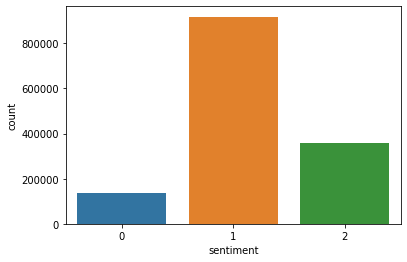

In [0]:
sns.countplot(prepr_df['sentiment'])
prepr_df['sentiment'].value_counts(normalize=True) * 100

In [0]:
# pd.get_dummies(prepr_df['sentiment'])
prepr_df = pd.concat([prepr_df,pd.get_dummies(prepr_df['sentiment'], prefix='sentiment')],axis=1)
prepr_df.drop(['sentiment'],axis=1,inplace=True)

In [0]:
prepr_df.rename(columns={'sentiment_0':'negative','sentiment_1':'neutral','sentiment_2':'positive',},inplace=True)

In [0]:
prepr_df.timestamp = pd.to_datetime(prepr_df.timestamp)


In [0]:
prepr_df.timestamp

0         2018-07-11 19:35:15.363270
1         2018-07-11 19:35:15.736769
2         2018-07-11 19:35:15.744769
3         2018-07-11 19:35:15.867339
4         2018-07-11 19:35:16.021448
                     ...            
1412996   2018-07-24 08:17:01.654579
1412997   2018-07-24 08:17:02.342093
1412998   2018-07-24 08:17:02.951448
1412999   2018-07-24 08:17:03.388879
1413000   2018-07-24 08:17:03.576424
Name: timestamp, Length: 1413001, dtype: datetime64[ns]

In [0]:
prepr_df = prepr_df.sort_values(by='timestamp')

In [0]:
# prepr_df=prepr_df[prepr_df.clean_tweets!='nan']


In [0]:
prepr_df.reset_index(drop=True,inplace=True)

In [0]:
new_df = prepr_df.groupby(prepr_df.timestamp.dt.to_period('Min')).sum()


In [0]:
new_df.reset_index(inplace=True)

In [0]:
new_df

,timestamp,negative,neutral,positive
0,2018-07-11 19:35,3,31,16
1,2018-07-11 19:36,4,36,18
2,2018-07-11 19:37,5,53,18
3,2018-07-11 19:38,1,40,10
4,2018-07-11 19:39,3,49,19
...,...,...,...,...
18038,2018-07-24 08:13,1,69,21
18039,2018-07-24 08:14,9,71,17
18040,2018-07-24 08:15,6,95,40
18041,2018-07-24 08:16,6,76,26


In [0]:
new_df.to_csv('/content/drive/My Drive/Colab Notebooks/tweets_final.csv')

# PART 2

In [0]:
tw_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tweets_final.csv')

In [0]:
tw_df.drop('Unnamed: 0',axis=1,inplace=True)

In [0]:
tw_df

,timestamp,negative,neutral,positive
0,2018-07-11 19:35,3,31,16
1,2018-07-11 19:36,4,36,18
2,2018-07-11 19:37,5,53,18
3,2018-07-11 19:38,1,40,10
4,2018-07-11 19:39,3,49,19
...,...,...,...,...
18038,2018-07-24 08:13,1,69,21
18039,2018-07-24 08:14,9,71,17
18040,2018-07-24 08:15,6,95,40
18041,2018-07-24 08:16,6,76,26


In [0]:
btc_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bitstampUSD.csv')

In [0]:
btc_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
btc_df['Timestamp'] = pd.to_datetime(btc_df['Timestamp'],unit='s')

In [0]:
btc_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3997692,2019-08-11 23:56:00,11555.57,11555.57,11540.37,11540.58,0.036868,425.909106,11552.336234
3997693,2019-08-11 23:57:00,11553.49,11556.22,11553.49,11556.22,0.623462,7204.428272,11555.520505
3997694,2019-08-11 23:58:00,11559.73,11561.22,11546.77,11561.22,0.159070,1838.731403,11559.252199
3997695,2019-08-11 23:59:00,11559.73,11589.73,11528.73,11528.73,16.198210,187504.635170,11575.638889


In [0]:
mask = (btc_df['Timestamp'] >= '2018-07-11 19:35') & (btc_df['Timestamp'] <= '2018-07-24 08:17')


In [0]:
btc_df = btc_df.loc[mask]

In [0]:
btc_df.reset_index(inplace=True,drop=True)
btc_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2018-07-11 19:35:00,6325.90,6327.93,6299.83,6300.00,285.687119,1.801016e+06,6304.156385
1,2018-07-11 19:36:00,6300.95,6304.08,6291.00,6293.04,142.725122,8.989601e+05,6298.541264
2,2018-07-11 19:37:00,6293.04,6300.00,6293.04,6295.50,9.574724,6.031536e+04,6299.435459
3,2018-07-11 19:38:00,6299.99,6306.99,6299.98,6306.99,130.653981,8.231237e+05,6300.027354
4,2018-07-11 19:39:00,6307.89,6312.63,6303.04,6307.96,2.452288,1.546638e+04,6306.917629
...,...,...,...,...,...,...,...,...
18038,2018-07-24 08:13:00,7988.99,7989.01,7982.75,7986.59,5.748321,4.591996e+04,7988.413456
18039,2018-07-24 08:14:00,7985.99,7993.98,7985.99,7993.98,1.626415,1.299918e+04,7992.532816
18040,2018-07-24 08:15:00,7991.78,8000.99,7991.78,8000.99,11.275343,9.019224e+04,7999.068113
18041,2018-07-24 08:16:00,7997.61,8003.95,7995.40,8000.14,2.959437,2.367199e+04,7998.813555


In [0]:
btc_tw_df = pd.concat([btc_df,tw_df],axis=1)

In [0]:
btc_tw_df.drop('timestamp',axis=1,inplace=True)
btc_tw_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,negative,neutral,positive
0,2018-07-11 19:35:00,6325.90,6327.93,6299.83,6300.00,285.687119,1.801016e+06,6304.156385,3,31,16
1,2018-07-11 19:36:00,6300.95,6304.08,6291.00,6293.04,142.725122,8.989601e+05,6298.541264,4,36,18
2,2018-07-11 19:37:00,6293.04,6300.00,6293.04,6295.50,9.574724,6.031536e+04,6299.435459,5,53,18
3,2018-07-11 19:38:00,6299.99,6306.99,6299.98,6306.99,130.653981,8.231237e+05,6300.027354,1,40,10
4,2018-07-11 19:39:00,6307.89,6312.63,6303.04,6307.96,2.452288,1.546638e+04,6306.917629,3,49,19
...,...,...,...,...,...,...,...,...,...,...,...
18038,2018-07-24 08:13:00,7988.99,7989.01,7982.75,7986.59,5.748321,4.591996e+04,7988.413456,1,69,21
18039,2018-07-24 08:14:00,7985.99,7993.98,7985.99,7993.98,1.626415,1.299918e+04,7992.532816,9,71,17
18040,2018-07-24 08:15:00,7991.78,8000.99,7991.78,8000.99,11.275343,9.019224e+04,7999.068113,6,95,40
18041,2018-07-24 08:16:00,7997.61,8003.95,7995.40,8000.14,2.959437,2.367199e+04,7998.813555,6,76,26


In [0]:
btc_tw_df['daily_change']=btc_tw_df['Close']-btc_tw_df['Open']

In [0]:
btc_tw_df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,negative,neutral,positive,daily_change
0,2018-07-11 19:35:00,6325.90,6327.93,6299.83,6300.00,285.687119,1.801016e+06,6304.156385,3,31,16,-25.90
1,2018-07-11 19:36:00,6300.95,6304.08,6291.00,6293.04,142.725122,8.989601e+05,6298.541264,4,36,18,-7.91
2,2018-07-11 19:37:00,6293.04,6300.00,6293.04,6295.50,9.574724,6.031536e+04,6299.435459,5,53,18,2.46
3,2018-07-11 19:38:00,6299.99,6306.99,6299.98,6306.99,130.653981,8.231237e+05,6300.027354,1,40,10,7.00
4,2018-07-11 19:39:00,6307.89,6312.63,6303.04,6307.96,2.452288,1.546638e+04,6306.917629,3,49,19,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...
18038,2018-07-24 08:13:00,7988.99,7989.01,7982.75,7986.59,5.748321,4.591996e+04,7988.413456,1,69,21,-2.40
18039,2018-07-24 08:14:00,7985.99,7993.98,7985.99,7993.98,1.626415,1.299918e+04,7992.532816,9,71,17,7.99
18040,2018-07-24 08:15:00,7991.78,8000.99,7991.78,8000.99,11.275343,9.019224e+04,7999.068113,6,95,40,9.21
18041,2018-07-24 08:16:00,7997.61,8003.95,7995.40,8000.14,2.959437,2.367199e+04,7998.813555,6,76,26,2.53


In [0]:
btc_tw_df.to_csv('/content/drive/My Drive/Colab Notebooks/btc_tw.csv')

In [0]:
btc_tw_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/btc_tw.csv')

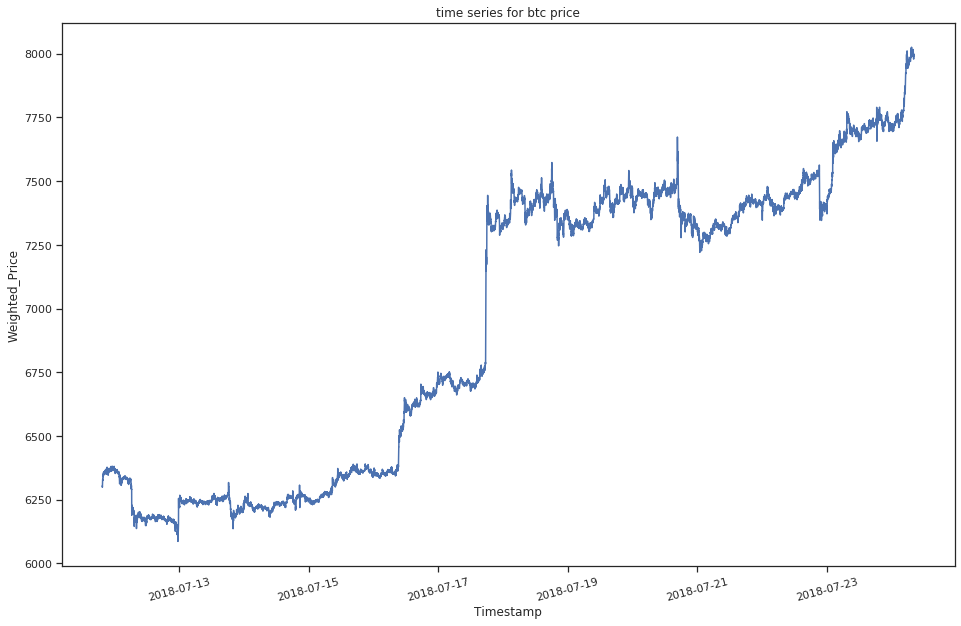

In [0]:
fig = plt.gcf()
fig.set_size_inches( 16, 10)
sns.lineplot(x="Timestamp", y="Weighted_Price", data=btc_tw_df)
plt.xticks(rotation=15)
plt.title('time series for btc price')
plt.show()

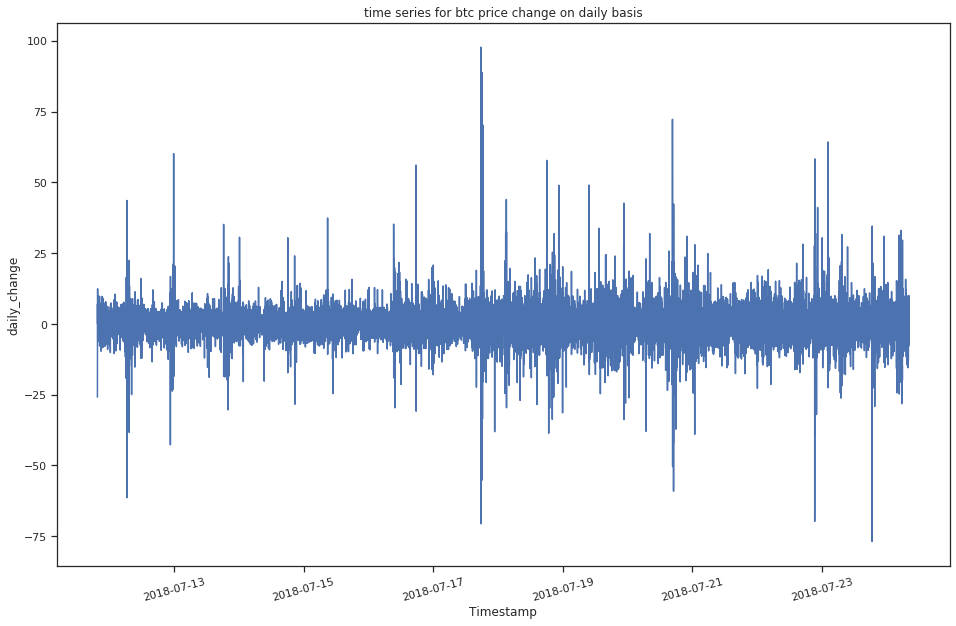

In [0]:
fig = plt.gcf()
fig.set_size_inches( 16, 10)
sns.lineplot(x="Timestamp", y="daily_change", data=btc_tw_df)
plt.xticks(rotation=15)
plt.title('time series for btc price change on daily basis')
plt.show()

## Construct time series model


### SARIMAX model

#### Stationarity check

In [0]:
btc_diff = pd.DataFrame(btc_tw_df.Weighted_Price.diff()).dropna()

In [27]:
btc_diff.head()

,Weighted_Price
1,-5.615121
2,0.894195
3,0.591895
4,6.890275
5,18.000057


In [24]:
results = sm.tsa.stattools.adfuller(btc_diff.Weighted_Price)
print(f"P-value:{results[1]}")

P-value:0.0


check with boxcox tranformation

In [45]:
btc_tw_df['Weighted_Price_box'], lmbda = stats.boxcox(btc_tw_df.Weighted_Price)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [46]:
btc_tw_df['Weighted_Price_box']

0        1.832158e+31
1        1.818378e+31
2        1.820566e+31
3        1.822016e+31
4        1.838968e+31
             ...     
18038    1.362018e+32
18039    1.367980e+32
18040    1.377485e+32
18041    1.377114e+32
18042    1.365494e+32
Name: Weighted_Price_box, Length: 18043, dtype: float64

In [0]:
btc_tw_box_df_diff = pd.DataFrame(btc_tw_df['Weighted_Price_box'].diff())

In [0]:
btc_tw_box_df_diff.dropna(inplace=True)

In [58]:
results = sm.tsa.stattools.adfuller(btc_tw_box_df_diff.Weighted_Price_box)
print(f"P-value:{results[1]}")

P-value:0.0


#### Plot ACF and PACF

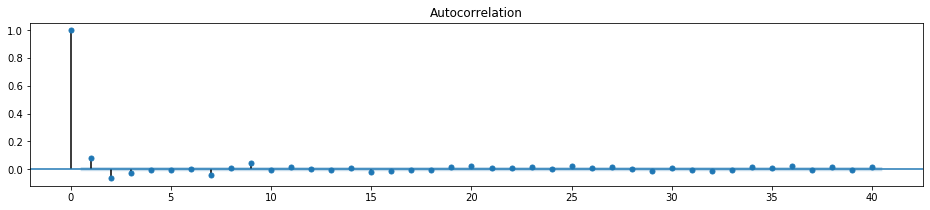

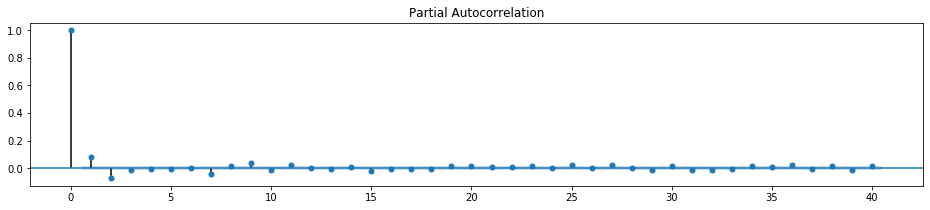

In [59]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(btc_tw_box_df_diff,ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(btc_tw_box_df_diff,ax=ax, lags=40);


#### Modelling

Train test split

In [0]:
index = round(len(btc_tw_df)*.80)
train = btc_tw_df.Weighted_Price_box.iloc[:index]
val = btc_tw_df.Weighted_Price_box.iloc[index:]

In [114]:
train

0        1.832158e+31
1        1.818378e+31
2        1.820566e+31
3        1.822016e+31
4        1.838968e+31
             ...     
14429    7.296795e+31
14430    7.296104e+31
14431    7.282150e+31
14432    7.378884e+31
14433    7.394922e+31
Name: Weighted_Price_box, Length: 14434, dtype: float64

In [0]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))


In [7]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [0]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [0]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters           aic
5   (0, 0, 2, 1)  2.487881e+06
3   (0, 0, 1, 1)  2.487899e+06
1   (0, 0, 0, 1)  2.487924e+06
45  (2, 1, 1, 1)  2.490279e+06
47  (2, 1, 2, 1)  2.490280e+06
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                18043
Model:             SARIMAX(0, 1, 0)x(2, 1, 1, 12)   Log Likelihood            -1243936.360
Date:                            Wed, 19 Feb 2020   AIC                        2487880.721
Time:                                    16:51:50   BIC                        2487911.920
Sample:                                         0   HQIC                       2487890.980
                                          - 18043                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


model fitting with best parameters

In [0]:
arima_model = sm.tsa.statespace.SARIMAX(train, 
                                        order=(0, 1, 0), 
                                        seasonal_order=(2, 1, 1, 12)
                                        )

# Fit the model and print results
output = arima_model.fit()

In [117]:
print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                14434
Model:             SARIMAX(0, 1, 0)x(2, 1, 1, 12)   Log Likelihood             -993826.839
Date:                            Thu, 20 Feb 2020   AIC                        1987661.679
Time:                                    13:01:10   BIC                        1987691.985
Sample:                                         0   HQIC                       1987671.753
                                          - 14434                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0367      0.003     11.181      0.000       0.030       0.043
ar.S.L24      -0.0359      0.002   

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [0]:
pickle.dump(arima_model, open("/content/drive/My Drive/Colab Notebooks/arima_model_v1.p", "wb"))

#### Predict validation set

In [0]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [118]:
# Values to test against the test set
fc   = output.get_forecast(len(val))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = invboxcox(fc.predicted_mean,lmbda)
lower_series = invboxcox(conf.iloc[:, 0],lmbda)
upper_series = invboxcox(conf.iloc[:, 1],lmbda)

etrain = invboxcox(train,lmbda)
etest  = invboxcox(val,lmbda)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start=0, dynamic=False)
pred        = invboxcox(predictions.predicted_mean,lmbda)

# Confidence interval for the training set
conf_int   = invboxcox(predictions.conf_int(),lmbda)
low_conf   = invboxcox(conf_int.iloc[:,0], lmbda)
upper_conf = invboxcox(conf_int.iloc[:,1], lmbda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [119]:
fc.predicted_mean

14434    7.397236e+31
14435    7.394648e+31
14436    7.394560e+31
14437    7.393472e+31
14438    7.394531e+31
             ...     
18038    8.758906e+31
18039    8.759391e+31
18040    8.759624e+31
18041    8.762790e+31
18042    8.760585e+31
Length: 3609, dtype: float64

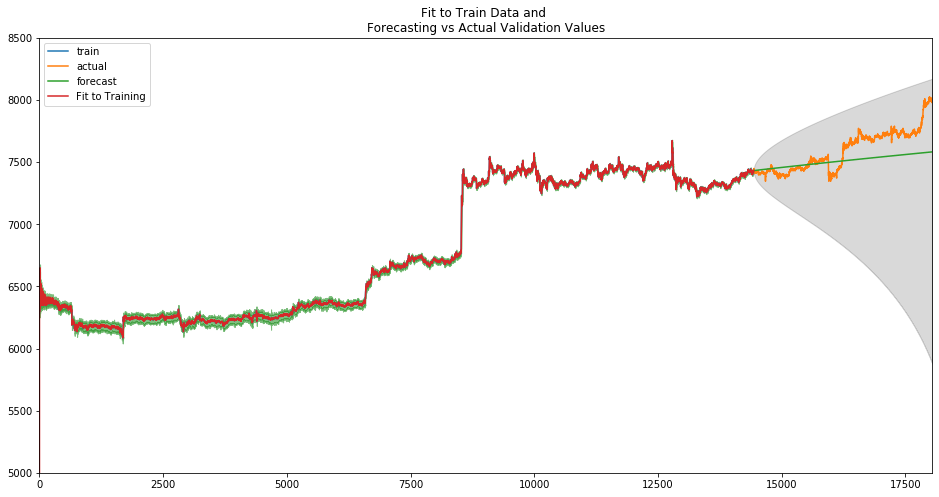

In [131]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 16, 8

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(etrain, label='train')
plt.plot(etest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# # Plotting against the training data
pred.plot(label='Fit to Training', )

# # # Confidence interval for the fitted data
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

# # # Limiting the viewing size
plt.ylim([5000, 8500])

plt.title('Fit to Train Data and \nForecasting vs Actual Validation Values')
plt.legend()
# plt.savefig('btc_fit_fc.png')
plt.show()

#### Calculate the RMSE for the model

In [134]:
forecast = pred
actual_val = etrain

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  53.141975363316725


### Facebook Prophet model

#### Modelling

In [0]:
prophet_model = Prophet(interval_width=0.95)

In [0]:
pp_train = btc_tw_df.iloc[:index]
pp_val = btc_tw_df.iloc[index:]

In [0]:
pp_train=pp_train[['Timestamp','Weighted_Price']]

In [152]:
pp_train.rename(columns={'Timestamp':'ds','Weighted_Price':'y'},inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [153]:
pp_train['ds'] = pd.DatetimeIndex(pp_train['ds'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [154]:
prophet_model.fit(pp_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


#### Predict validation set

In [163]:
future_dates = prophet_model.make_future_dataframe(periods=3609, freq='min')
future_dates.tail()

,ds
18038,2018-07-24 08:13:00
18039,2018-07-24 08:14:00
18040,2018-07-24 08:15:00
18041,2018-07-24 08:16:00
18042,2018-07-24 08:17:00


In [0]:
forecast = prophet_model.predict(future_dates)

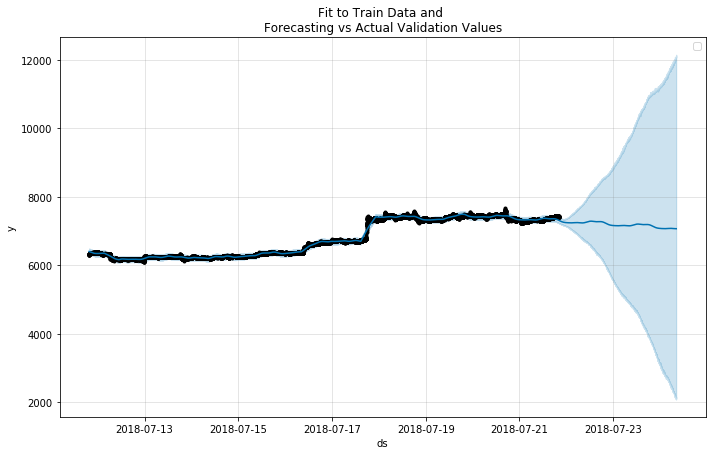

In [166]:
prophet_model.plot(forecast, uncertainty=True)
plt.title('Fit to Train Data and \nForecasting vs Actual Validation Values')
plt.legend()
plt.show()
plt.show()

In [169]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-07-11 19:35:00,6374.565700,6317.925996,6479.172709,6374.565700,6374.565700,25.407869,25.407869,25.407869,25.407869,25.407869,25.407869,0.0,0.0,0.0,6399.973569
1,2018-07-11 19:36:00,6374.602619,6316.089103,6474.067724,6374.602619,6374.602619,25.019743,25.019743,25.019743,25.019743,25.019743,25.019743,0.0,0.0,0.0,6399.622362
2,2018-07-11 19:37:00,6374.639538,6319.479270,6474.438271,6374.639538,6374.639538,24.629614,24.629614,24.629614,24.629614,24.629614,24.629614,0.0,0.0,0.0,6399.269152
3,2018-07-11 19:38:00,6374.676457,6326.110411,6483.391704,6374.676457,6374.676457,24.237526,24.237526,24.237526,24.237526,24.237526,24.237526,0.0,0.0,0.0,6398.913983
4,2018-07-11 19:39:00,6374.713376,6320.286263,6474.849709,6374.713376,6374.713376,23.843524,23.843524,23.843524,23.843524,23.843524,23.843524,0.0,0.0,0.0,6398.556900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18038,2018-07-24 08:13:00,7087.568078,2085.670000,12100.726115,2127.403691,12096.862032,-22.415067,-22.415067,-22.415067,-22.415067,-22.415067,-22.415067,0.0,0.0,0.0,7065.153011
18039,2018-07-24 08:14:00,7087.509387,2156.984715,12120.743471,2124.769353,12100.178324,-22.339229,-22.339229,-22.339229,-22.339229,-22.339229,-22.339229,0.0,0.0,0.0,7065.170158
18040,2018-07-24 08:15:00,7087.450695,2134.747635,12071.006530,2122.135015,12103.494617,-22.260662,-22.260662,-22.260662,-22.260662,-22.260662,-22.260662,0.0,0.0,0.0,7065.190033
18041,2018-07-24 08:16:00,7087.392004,2102.155251,12147.822582,2119.500676,12106.810909,-22.179345,-22.179345,-22.179345,-22.179345,-22.179345,-22.179345,0.0,0.0,0.0,7065.212659


#### Calculate the RMSE for the model

In [171]:
rmse = np.sqrt(((forecast.yhat - btc_tw_df.Weighted_Price) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  210.17639230164866


### RNN Model